## Imports and loading the data

In [ ]:
#imports
from matplotlib import pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import torch
import scipy
layers = tf.keras.layers
models = tf.keras.models
keras = tf.keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Activation, Dropout, MaxPooling2D, Flatten, GlobalMaxPooling2D, BatchNormalization, LeakyReLU, Input, Normalization

In [ ]:
"""
# Download the data stored in a zipped numpy array from one of these two locations
# The uncommented one is likely to be faster. If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it 
# rather than repeatedly downloading it.

#!wget "http://users.sussex.ac.uk/~is321/training_images.npz" -O training_images.npz
!wget "https://sussex.box.com/shared/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz" -O training_images.npz

# The test images (without points)
#!wget "http://users.sussex.ac.uk/~is321/test_images.npz" -O test_images.npz
!wget "https://sussex.box.com/shared/static/xxlgvjpa86s6xgjzy5im06saoj57s7gt.npz" -O test_images.npz

# The example images are here
#!wget "http://users.sussex.ac.uk/~is321/examples.npz" -O examples.npz
!wget "https://sussex.box.com/shared/static/kbodelmaqw5dd59i5x2kis55lor7ydhf.npz" -O examples.npz
"""

'\n# Download the data stored in a zipped numpy array from one of these two locations\n# The uncommented one is likely to be faster. If you\'re running all your experiments\n# on a machine at home rather than using colab, then make sure you save it \n# rather than repeatedly downloading it.\n\n#!wget "http://users.sussex.ac.uk/~is321/training_images.npz" -O training_images.npz\n!wget "https://sussex.box.com/shared/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz" -O training_images.npz\n\n# The test images (without points)\n#!wget "http://users.sussex.ac.uk/~is321/test_images.npz" -O test_images.npz\n!wget "https://sussex.box.com/shared/static/xxlgvjpa86s6xgjzy5im06saoj57s7gt.npz" -O test_images.npz\n\n# The example images are here\n#!wget "http://users.sussex.ac.uk/~is321/examples.npz" -O examples.npz\n!wget "https://sussex.box.com/shared/static/kbodelmaqw5dd59i5x2kis55lor7ydhf.npz" -O examples.npz\n'

In [ ]:
try:
  # Load the data using np.load
  data = np.load('training_images.npz', allow_pickle=True)
  test_data = np.load('test_images.npz', allow_pickle=True)
  examples_data = np.load('examples.npz', allow_pickle=True)
except:
  try:
    #COLAB load data
    from google.colab import drive
    drive.mount('/content/drive')
    # Load the data using np.load
    data = np.load('/content/drive/MyDrive/Colab Notebooks/CV assignment/training_images.npz', allow_pickle=True)
    test_data = np.load('/content/drive/MyDrive/Colab Notebooks/CV assignment/test_images.npz', allow_pickle=True)
    examples_data = np.load('/content/drive/MyDrive/Colab Notebooks/CV assignment/examples.npz', allow_pickle=True)
  except:
    print('data not found')
# Extract the images
images_original = data['images']
# and the data points
pts = data['points']

print(images_original.shape, pts.shape)

test_images_original = test_data['images']
print(test_images_original.shape)

examples_original = examples_data['images']
print(examples_original.shape)
print(images_original.dtype)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Exception ignored in: <function NpzFile.__del__ at 0x7f18b9a5acb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 224, in __del__
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 219, in close
OSError: [Errno 107] Transport endpoint is not connected
Exception ignored in: <function NpzFile.__del__ at 0x7f18b9a5acb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 224, in __del__
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 219, in close
OSError: [Errno 107] Transport endpoint is not connected
Exception ignored in: <function NpzFile.__del__ at 0x7f18b9a5acb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 224, in __del__
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 219, in close
OSError: [Errno 107] Transport endpoint is not conne

(2811, 244, 244, 3) (2811, 42, 2)
(554, 244, 244, 3)
(6, 244, 244, 3)
uint8


In [ ]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))

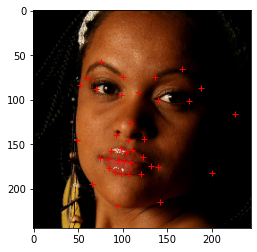

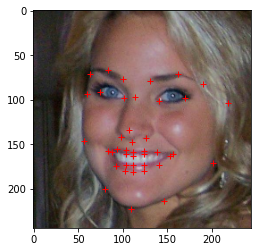

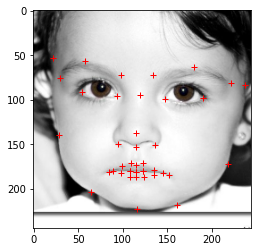

In [ ]:
def visualise_pts(img, pts):
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

for i in range(3):
  idx = np.random.randint(0, images_original.shape[0])
  visualise_pts(images_original[idx, ...], pts[idx, ...])

##Preprocessing

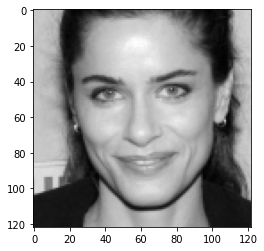

In [ ]:
#resize and grayscale the data
def resize_and_rgb2grayscale(input_data):
    preprocessed_data = np.ndarray((input_data.shape[0],122,122),dtype=input_data.dtype)
    for (i,img) in enumerate(input_data):
      preprocessed_data[i] = np.uint8(np.mean(cv2.resize(img, (122,122,), interpolation=cv2.INTER_AREA),axis=-1))
    return preprocessed_data

images = resize_and_rgb2grayscale(images_original)
test_images = resize_and_rgb2grayscale(test_images_original)
examples = resize_and_rgb2grayscale(examples_original)
plt.imshow(images[0],cmap='gray')

In [ ]:
#split the data to training and val data
split = np.uint32(images.shape[0]*.8)
train_imgs = images[:split]
train_pts = pts[:split]
val_imgs = images[split:]
val_pts = pts[split:]


In [ ]:
#image rotation (part of training data augmentation)
def rotate(img,points,angle,origin):
  theta = np.deg2rad(-angle)

  rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
  im = scipy.ndimage.rotate(img,angle,reshape=False)

  return im,np.array([np.dot(rot,point-origin)+origin for point in points])

In [ ]:
r_clockwise_imgs  = np.copy(train_imgs)
r_clockwise_pts  = np.copy(train_pts)
r_anticlockwise_imgs  = np.copy(train_imgs)
r_anticlockwise_pts  = np.copy(train_pts)
r_anticlockwise_val_imgs  = np.copy(val_imgs)
r_anticlockwise_val_pts  = np.copy(val_pts)
r_clockwise_val_imgs  = np.copy(val_imgs)
r_clockwise_val_pts  = np.copy(val_pts)
for i in range(train_imgs.shape[0]):
  r_clockwise_imgs[i], r_clockwise_pts[i] = rotate(train_imgs[i],train_pts[i],-10,122)
  r_anticlockwise_imgs[i], r_anticlockwise_pts[i] = rotate(train_imgs[i],train_pts[i],10,122)
for i in range(val_imgs.shape[0]):
  r_clockwise_val_imgs[i], r_clockwise_val_pts[i] = rotate(val_imgs[i],val_pts[i],-10,122)
  r_anticlockwise_val_imgs[i], r_anticlockwise_val_pts[i] = rotate(val_imgs[i],val_pts[i],10,122)

(-0.5, 121.5, 121.5, -0.5)

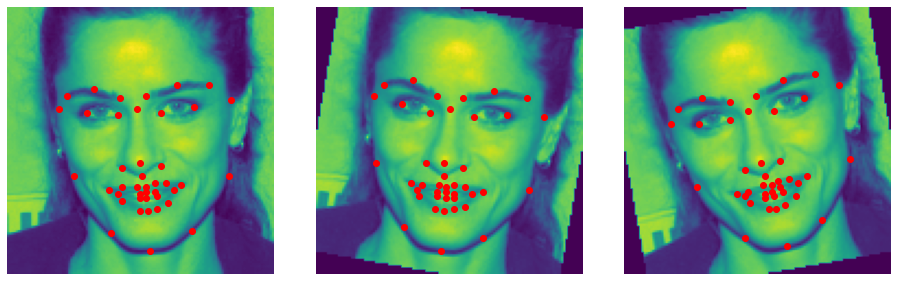

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(13,10))
fig.tight_layout()
axs[0].imshow(images[0])
axs[0].plot(pts[0,:,0]//2, pts[0,:,1]//2, 'or')
axs[0].axis('off')

axs[1].imshow(r_clockwise_imgs[0])
axs[1].plot(r_clockwise_pts[0,:,0]//2, r_clockwise_pts[0,:,1]//2, 'or')
axs[1].axis('off')

axs[2].imshow(r_anticlockwise_imgs[0])
axs[2].plot(r_anticlockwise_pts[0,:,0]//2, r_anticlockwise_pts[0,:,1]//2, 'or')
axs[2].axis('off')
#fig.savefig('/content/drive/MyDrive/Colab Notebooks/CV assignment/figures/rotation')

In [ ]:
#concat and shuffle the train data
all_imgs = np.concatenate([train_imgs,val_imgs,r_clockwise_imgs,r_anticlockwise_imgs,r_clockwise_val_imgs,r_anticlockwise_val_imgs],axis=0)
all_pts = np.concatenate([train_pts,val_pts,r_clockwise_pts,r_anticlockwise_pts,r_clockwise_val_pts,r_anticlockwise_val_pts],axis=0)
train_imgss = np.concatenate([train_imgs,r_clockwise_imgs,r_anticlockwise_imgs],axis=0)
train_ptss = np.concatenate([train_pts,r_clockwise_pts,r_anticlockwise_pts],axis=0)

indicies = np.random.shuffle(np.arange(train_imgss.shape[0]))
train_imgss = train_imgss[indicies]
train_ptss = train_ptss[indicies]
train_imgss = train_imgss[0]
train_ptss = train_ptss[0]
indicies = np.random.shuffle(np.arange(all_imgs.shape[0]))
all_imgs = all_imgs[indicies]
all_pts = all_pts[indicies]
all_imgs = all_imgs[0]
all_pts = all_pts[0]

(-0.5, 121.5, 121.5, -0.5)

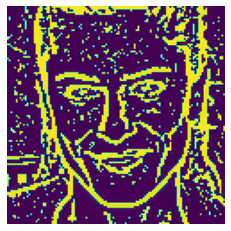

In [ ]:
#gaussian diff
ttt = np.copy(train_imgs)
vvv = np.copy(val_imgs)
for i in range(vvv.shape[0]):
  lowv = cv2.GaussianBlur(vvv[i],(3,3),0)
  highv = cv2.GaussianBlur(vvv[i],(5,5),0)
  vvv[i] = lowv - highv
for i in range(ttt.shape[0]):
  low = cv2.GaussianBlur(ttt[i],(3,3),0)
  high = cv2.GaussianBlur(ttt[i],(5,5),0)
  ttt[i] = low- high
plt.imshow(ttt[0])
plt.axis('off')

In [ ]:
#vectorize pts
pts = np.reshape(pts,(pts.shape[0],84))
all_pts = np.reshape(all_pts,(all_pts.shape[0],84))
train_ptss = np.reshape(train_ptss,(train_ptss.shape[0],84))
train_pts = np.reshape(train_pts,(train_pts.shape[0],84))
val_pts = np.reshape(val_pts,(val_pts.shape[0],84))

##Model

In [ ]:
#building and tuning the model
class FaceAlignment(Sequential):
  
  def compile(self):
    adam = keras.optimizers.Adam(learning_rate=0.0008)
    super(FaceAlignment,self).compile(loss='mean_squared_error', optimizer=adam)

class RandomContrastCustom(keras.layers.Layer):
  def __init__(self, std=.3, **kwargs):    
    super(RandomContrastCustom, self).__init__(**kwargs)
    self.std = std

  def call(self,images,training=None):
    if not training:
      return images
    mean = tf.math.reduce_mean(images,[1,2],keepdims=True)
    return (images - mean) * tf.random.normal([1],1,self.std) + mean

  def get_config(self):
      return {"std": self.std}

  @classmethod
  def from_config(cls, config):
      return cls(**config)


In [ ]:
model = FaceAlignment(
[
 BatchNormalization(input_shape=(122,122,1))
,RandomContrastCustom()
,Conv2D(32,kernel_size=(3, 3), activation='relu', padding='same')
,LeakyReLU()
,Dropout(.1)
,MaxPooling2D(pool_size=(2, 2))
,Conv2D(64,kernel_size=(3, 3), activation='relu', padding='same')
,LeakyReLU()
,Dropout(.1)
,MaxPooling2D(pool_size=(2, 2))
,Conv2D(128,kernel_size=(3, 3), activation='relu', padding='same')
,LeakyReLU()
,Dropout(.1)
,Flatten()
,Dense(256, activation='relu')
,Dense(256, activation='relu')
,Dense(84,)])

model.compile()
#with data augmentation
hist_data = model.fit(train_imgss,train_ptss,epochs=80,validation_data=(val_imgs,val_pts))
#without data augmentation
#hist_data = model.fit(train_imgs,train_pts,epochs=80,validation_data=(val_imgs,val_pts))

Epoch 1/80
211/211 [==============================] - 20s 38ms/step - loss: 3153.5925 - val_loss: 850.0320
Epoch 2/80
211/211 [==============================] - 8s 37ms/step - loss: 215.1365 - val_loss: 297.3237
Epoch 3/80
211/211 [==============================] - 8s 37ms/step - loss: 138.2550 - val_loss: 311.1942
Epoch 4/80
211/211 [==============================] - 8s 37ms/step - loss: 119.9849 - val_loss: 230.9799
Epoch 5/80
211/211 [==============================] - 8s 36ms/step - loss: 99.9739 - val_loss: 287.4560
Epoch 6/80
211/211 [==============================] - 8s 37ms/step - loss: 78.4777 - val_loss: 336.3130
Epoch 7/80
211/211 [==============================] - 8s 36ms/step - loss: 68.3198 - val_loss: 115.8422
Epoch 8/80
211/211 [==============================] - 8s 37ms/step - loss: 63.0509 - val_loss: 175.4248
Epoch 9/80
211/211 [==============================] - 8s 37ms/step - loss: 52.4322 - val_loss: 205.1059
Epoch 10/80
211/211 [==============================] - 8s 

In [ ]:
#model.save('/content/drive/MyDrive/Colab Notebooks/CV assignment/my_model_final_2')
#np.save('/content/drive/MyDrive/Colab Notebooks/CV assignment/h1.npy',hist_data.history)
history = hist_data.history

In [ ]:
#model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CV assignment/my_model_final')
#history = np.load('/content/drive/MyDrive/Colab Notebooks/CV assignment/h1.npy',allow_pickle=True)

(0.0, 130.0)

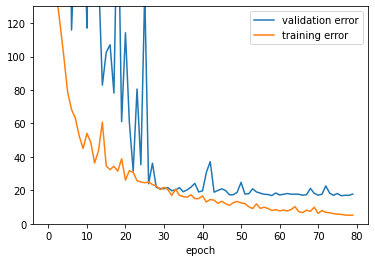

In [ ]:
ep_start = 0
plt.plot(range(ep_start,len(history['loss'])),list(zip(history['val_loss'][ep_start:],history['loss'][ep_start:])))
plt.xlabel('epoch')
plt.legend(['validation error','training error'])
plt.ylim(0,130)
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/CV assignment/training_lol')

Text(0, 0.5, 'Number of images')

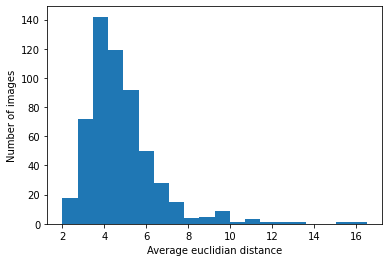

In [ ]:
val_preds = model.predict(val_imgs)
val_preds = np.reshape(val_preds,(val_preds.shape[0],42,2))

ev_dists = np.zeros((val_imgs.shape[0]))
for i in range(ev_dists.shape[0]):
  ev_dists[i] = np.mean(euclid_dist(val_preds[i],val_pts[i]))
ev_dists

plt.hist(ev_dists,bins=20)
plt.xlabel('Average euclidian distance')
plt.ylabel('Number of images')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/CV assignment/figures/euclid_dists')

In [ ]:
val_ptsss = np.reshape(val_pts,(val_pts.shape[0],42,2))
ev_oval = np.zeros((val_imgs.shape[0]))
ev_eybr = np.zeros((val_imgs.shape[0]))
ev_nose = np.zeros((val_imgs.shape[0]))
ev_eyes = np.zeros((val_imgs.shape[0]))
ev_lips = np.zeros((val_imgs.shape[0]))

oval_inds = range(0,7)
eybr_inds = range(7,13)
nose_inds = range(14,18)
eye_inds = range(18,22)
lips_inds = range(22,42)
for i in range(ev_eyes.shape[0]):
  ev_eyes[i] = np.mean(euclid_dist(val_preds[i,eye_inds],val_ptsss[i,eye_inds]))
for i in range(ev_nose.shape[0]):
  ev_nose[i] = np.mean(euclid_dist(val_preds[i,nose_inds],val_ptsss[i,nose_inds]))
for i in range(ev_oval.shape[0]):
  ev_oval[i] = np.mean(euclid_dist(val_preds[i,oval_inds],val_ptsss[i,oval_inds]))
for i in range(ev_lips.shape[0]):
  ev_lips[i] = np.mean(euclid_dist(val_preds[i,lips_inds],val_ptsss[i,lips_inds]))
for i in range(ev_eybr.shape[0]):
  ev_eybr[i] = np.mean(euclid_dist(val_preds[i,eybr_inds],val_ptsss[i,eybr_inds]))

Text(0, 0.5, 'Average euclidian distance')

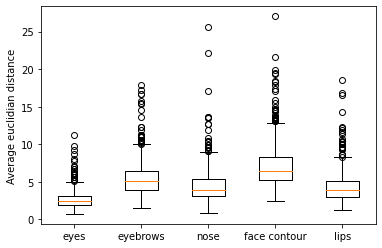

In [ ]:
plt.boxplot((ev_eyes,ev_eybr,ev_nose,ev_oval,ev_lips))
plt.xticks([1,2,3,4,5],['eyes','eyebrows','nose','face contour','lips'])
plt.ylabel('Average euclidian distance')

mean:  4.791489917721885
min:  1.9972906251809073
max:  16.501065447903848
median:  4.419157266530517
std:  1.7032240898093718
less than 4:  35.17 %
less than 5:  65.36 %
less than 6:  84.01 %
less than 7:  92.36 %
less than 8:  95.74 %
less than 9:  96.63 %
less than 10:  98.40 %


Text(0, 0.5, 'Average euclidian distance')

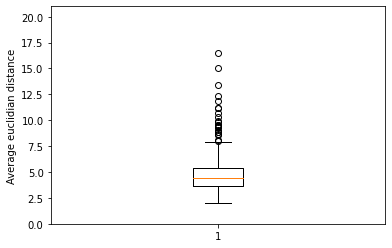

In [ ]:
mean = np.mean(ev_dists)
min = (ev_dists).min()
max = (ev_dists).max()
median = np.median(ev_dists)
std = np.std(ev_dists)
print("mean: ", mean)
print("min: ", min)
print("max: ", max)
print("median: ", median)
print("std: ", std)
print("less than 4: ", '{:.2f}'.format((ev_dists < 4).sum()/ev_dists.shape[0]*100),'%')
print("less than 5: ", '{:.2f}'.format((ev_dists < 5).sum()/ev_dists.shape[0]*100),'%')
print("less than 6: ", '{:.2f}'.format((ev_dists < 6).sum()/ev_dists.shape[0]*100),'%')
print("less than 7: ", '{:.2f}'.format((ev_dists < 7).sum()/ev_dists.shape[0]*100),'%')
print("less than 8: ", '{:.2f}'.format((ev_dists < 8).sum()/ev_dists.shape[0]*100),'%')
print("less than 9: ", '{:.2f}'.format((ev_dists < 9).sum()/ev_dists.shape[0]*100),'%')
print("less than 10: ", '{:.2f}'.format((ev_dists < 10).sum()/ev_dists.shape[0]*100),'%')
plt.boxplot(ev_dists)
plt.ylim(0,21)
plt.ylabel('Average euclidian distance')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/CV assignment/figures/euclid_dists2')

In [ ]:
#training on the whole dataset with optimal number of epochs
final_model = FaceAlignment(
[
 BatchNormalization(input_shape=(122,122,1))
,RandomContrastCustom()
,Conv2D(32,kernel_size=(3, 3), activation='relu', padding='same')
,LeakyReLU()
,Dropout(.1)
,MaxPooling2D(pool_size=(2, 2))
,Conv2D(64,kernel_size=(3, 3), activation='relu', padding='same')
,LeakyReLU()
,Dropout(.1)
,MaxPooling2D(pool_size=(2, 2))
,Conv2D(128,kernel_size=(3, 3), activation='relu', padding='same')
,LeakyReLU()
,Dropout(.1)
,Flatten()
,Dense(256, activation='relu')
,Dense(256, activation='relu')
,Dense(84,)])

final_model.compile()
final_model.fit(all_imgs,all_pts,epochs=30)

Epoch 1/30
264/264 [==============================] - 10s 36ms/step - loss: 2201.5029
Epoch 2/30
264/264 [==============================] - 9s 35ms/step - loss: 157.7362
Epoch 3/30
264/264 [==============================] - 9s 35ms/step - loss: 84.8275
Epoch 4/30
264/264 [==============================] - 9s 35ms/step - loss: 63.7550
Epoch 5/30
264/264 [==============================] - 9s 35ms/step - loss: 59.8034
Epoch 6/30
264/264 [==============================] - 9s 35ms/step - loss: 47.8395
Epoch 7/30
264/264 [==============================] - 9s 35ms/step - loss: 51.9418
Epoch 8/30
264/264 [==============================] - 9s 35ms/step - loss: 43.8253
Epoch 9/30
264/264 [==============================] - 9s 35ms/step - loss: 43.8400
Epoch 10/30
264/264 [==============================] - 9s 35ms/step - loss: 37.6768
Epoch 11/30
264/264 [==============================] - 9s 35ms/step - loss: 41.2546
Epoch 12/30
264/264 [==============================] - 9s 35ms/step - loss: 34.22

In [ ]:
#model.save('/content/drive/MyDrive/Colab Notebooks/CV assignment/my_model_final_full')

In [ ]:
#model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CV assignment/my_model_final_full')

Text(0, 0.5, 'Number of images')

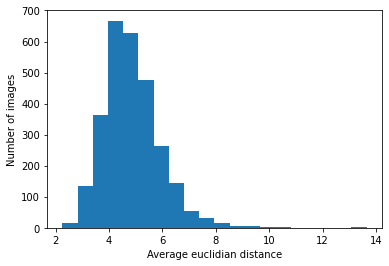

In [ ]:
ppreds = final_model.predict(images)
ppreds = np.reshape(ppreds,(ppreds.shape[0],42,2))

ev_dists = np.zeros((images.shape[0]))
for i in range(ev_dists.shape[0]):
  ev_dists[i] = np.mean(euclid_dist(ppreds[i],pts[i]))
ev_dists

plt.hist(ev_dists,bins=20)
plt.xlabel('Average euclidian distance')
plt.ylabel('Number of images')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/CV assignment/figures/euclid_dists')

mean:  4.851834891849867
min:  2.247158812246648
max:  13.65148615281636
median:  4.72026038952951
std:  1.0638823219770674
less than 4:  20.24 %
less than 5:  60.87 %
less than 6:  87.34 %
less than 7:  96.55 %
less than 8:  98.90 %
less than 9:  99.47 %
less than 10:  99.82 %


Text(0, 0.5, 'Average euclidian distance')

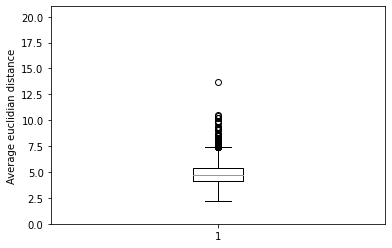

In [ ]:
mean = np.mean(ev_dists)
min = (ev_dists).min()
max = (ev_dists).max()
median = np.median(ev_dists)
std = np.std(ev_dists)
print("mean: ", mean)
print("min: ", min)
print("max: ", max)
print("median: ", median)
print("std: ", std)
print("less than 4: ", '{:.2f}'.format((ev_dists < 4).sum()/ev_dists.shape[0]*100),'%')
print("less than 5: ", '{:.2f}'.format((ev_dists < 5).sum()/ev_dists.shape[0]*100),'%')
print("less than 6: ", '{:.2f}'.format((ev_dists < 6).sum()/ev_dists.shape[0]*100),'%')
print("less than 7: ", '{:.2f}'.format((ev_dists < 7).sum()/ev_dists.shape[0]*100),'%')
print("less than 8: ", '{:.2f}'.format((ev_dists < 8).sum()/ev_dists.shape[0]*100),'%')
print("less than 9: ", '{:.2f}'.format((ev_dists < 9).sum()/ev_dists.shape[0]*100),'%')
print("less than 10: ", '{:.2f}'.format((ev_dists < 10).sum()/ev_dists.shape[0]*100),'%')
plt.boxplot(ev_dists)
plt.ylim(0,21)
plt.ylabel('Average euclidian distance')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/CV assignment/figures/euclid_dists2')

In [ ]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==2*42, 'wrong number of points provided. There should be 42 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')


pred = final_model.predict(test_images)
pred = np.reshape(pred,(pred.shape[0],42,2))
#save_as_csv(pred, '/content/drive/MyDrive/Colab Notebooks/CV assignment')

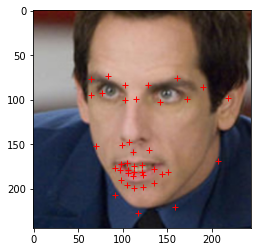

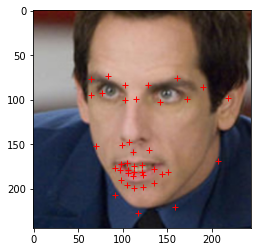

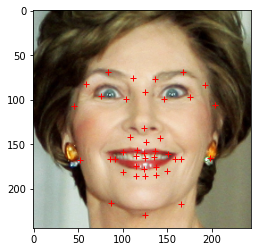

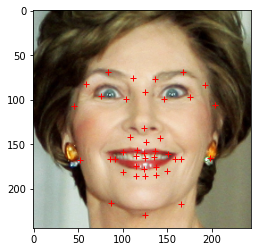

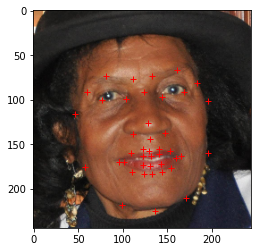

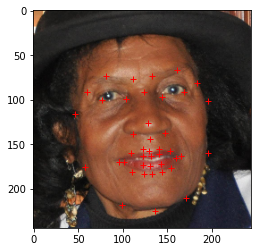

In [ ]:
preda = model.predict(test_images)
preda = np.reshape(pred,(pred.shape[0],42,2))
for i in range(3):
  idx = np.random.randint(0, test_images_original.shape[0])
  visualise_pts(test_images_original[idx],pred[idx])
  visualise_pts(test_images_original[idx],preda[idx])

In [ ]:
predss = final_model.predict(val_imgs)
predss = np.reshape(predss,(predss.shape[0],42,2))
a = [np.mean(euclid_dist(predss[i],val_pts[i])) for i in range(val_pts.shape[0])]
print(np.mean(a))

4.829538992693492


In [ ]:

e_pred = final_model.predict(examples)
e_pred = np.reshape(e_pred,(e_pred.shape[0],42,2))

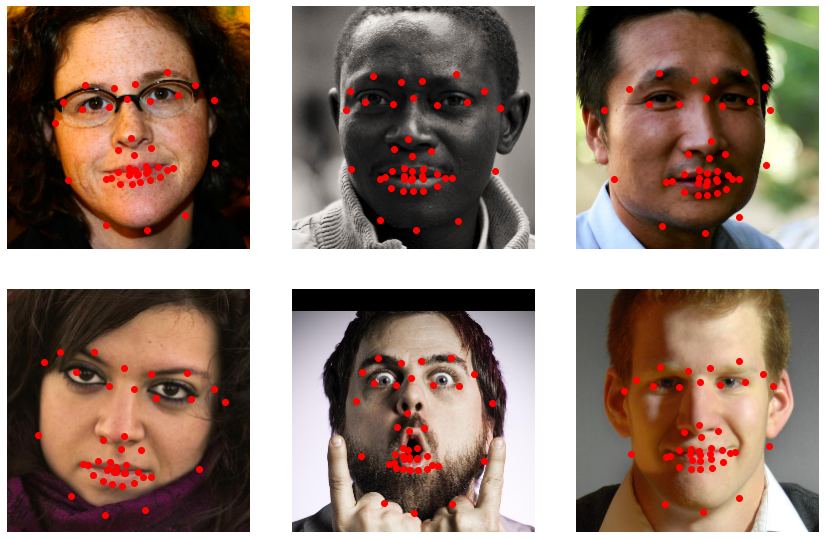

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(12,8))
fig.tight_layout()
o = 0
for i in [0,2,4]:
  axs[0,o].imshow(examples_original[i])
  axs[0,o].plot(e_pred[i,:,0],e_pred[i,:,1], 'or')
  axs[0,o].axis('off')

  axs[1,o].imshow(examples_original[i+1])
  axs[1,o].plot(e_pred[i+1,:,0],e_pred[i+1,:,1], 'or',linewidth=.5)
  axs[1,o].axis('off')

  o += 1

#fig.savefig('/content/drive/MyDrive/Colab Notebooks/CV assignment/figures/example_preds')

##Lipstick and Iris

(-0.5, 243.5, 243.5, -0.5)

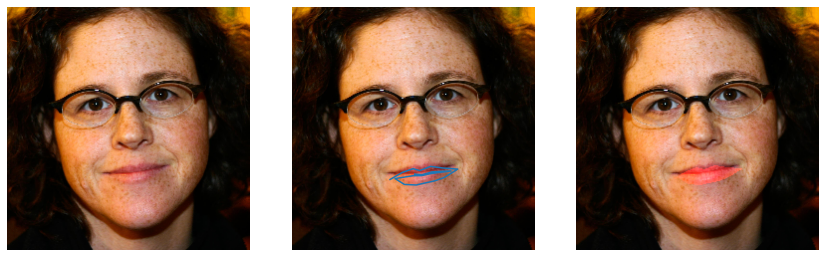

In [ ]:
#lips
def Lipstick(img,pts,color=(255,0,0),strength=.3):
  pt = np.int32(pts[22:42])
  lips = np.zeros_like(img)
  cv2.fillPoly(lips,[pt],color)
  return cv2.addWeighted(img,1,lips,strength,0)
#plt.imshow(Lipstick(images_original[g],np.reshape(pts[g],(42,2))))
fig, axs = plt.subplots(1,3,figsize=(12,4))
fig.tight_layout()
axs[0].imshow(examples_original[0])
axs[0].axis('off')
axs[1].imshow(examples_original[0])
axs[1].plot(e_pred[0,22:42,0],e_pred[0,22:42,1])
axs[1].axis('off')
axs[2].imshow(Lipstick(examples_original[0],e_pred[0]))
axs[2].axis('off')
#fig.savefig('/content/drive/MyDrive/Colab Notebooks/CV assignment/figures/lipstick')

(-0.5, 243.5, 243.5, -0.5)

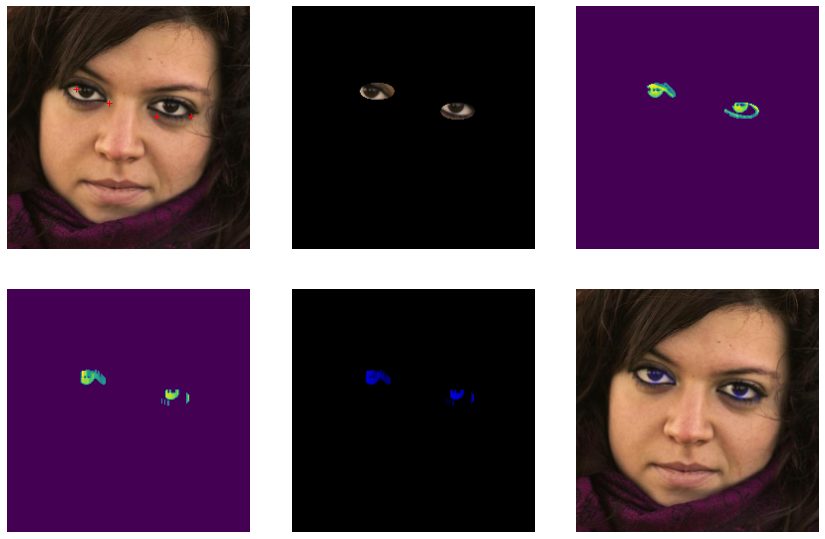

In [ ]:
#eyes

def eyeMask(img,pts):
  
  mask = np.zeros_like(img)

  left_center = (np.uint8((pts[18,0]+pts[19,0])//2),np.uint8((pts[18,1]+pts[19,1])//2)-4)
  right_center = (np.uint8((pts[20,0]+pts[21,0])//2),np.uint8((pts[20,1]+pts[21,1])//2)-4)
  width = np.uint8(np.abs(((pts[18,0]-pts[19,0])//2)))
  height = width//2
  cv2.ellipse(mask, left_center, (width,height),0,0,360,(1,1,1),-1)
  cv2.ellipse(mask, right_center, (width,height),0,0,360,(1,1,1),-1)

  plot2 = img*mask
  axs[0,1].imshow(plot2)

  return mask

def irisMask(eyeMask, im):
    eyes = (im*(-1)+255) * eyeMask
    eyes = np.uint8(np.mean(eyes,axis=-1))
    eyes = cv2.equalizeHist(eyes)
    eyes = np.clip(eyes,100,255)
    below_100 = eyes == 100
    eyes[below_100] = 0

    plot3 = eyes
    axs[0,2].imshow(plot3)

    eyes = cv2.erode(eyes, (5,5),iterations=4)
    eyes = cv2.dilate(eyes, (5,5),iterations=4)

    plot4 = eyes
    axs[1,0].imshow(plot4)

    return eyes


def changeIrisColor(img,irisMask,color=(0,0,255),strength=.3):
  irisMask = np.reshape(irisMask,(244,244,1))
  irisMask = np.ones_like(img) * irisMask
  new_eyes = np.uint8((irisMask/255 * color))

  plot5 = new_eyes
  axs[1,1].imshow(plot5)
  return cv2.addWeighted(img,1,new_eyes,strength,0)

fig, axs = plt.subplots(2,3,figsize=(12,8))
fig.tight_layout()
g = 1
pt = e_pred[g]
e_mask = eyeMask(examples_original[g],pt)
iris_mask = irisMask(e_mask,examples_original[g])
plot6 = changeIrisColor(examples_original[g],iris_mask)
plot1 = examples_original[g]
axs[0,0].imshow(plot1)
axs[0,0].plot(pt[18:22, 0], pt[18:22, 1], '+r')
axs[1,2].imshow(plot6)
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')
#fig.savefig('/content/drive/MyDrive/Colab Notebooks/CV assignment/figures/eyes')

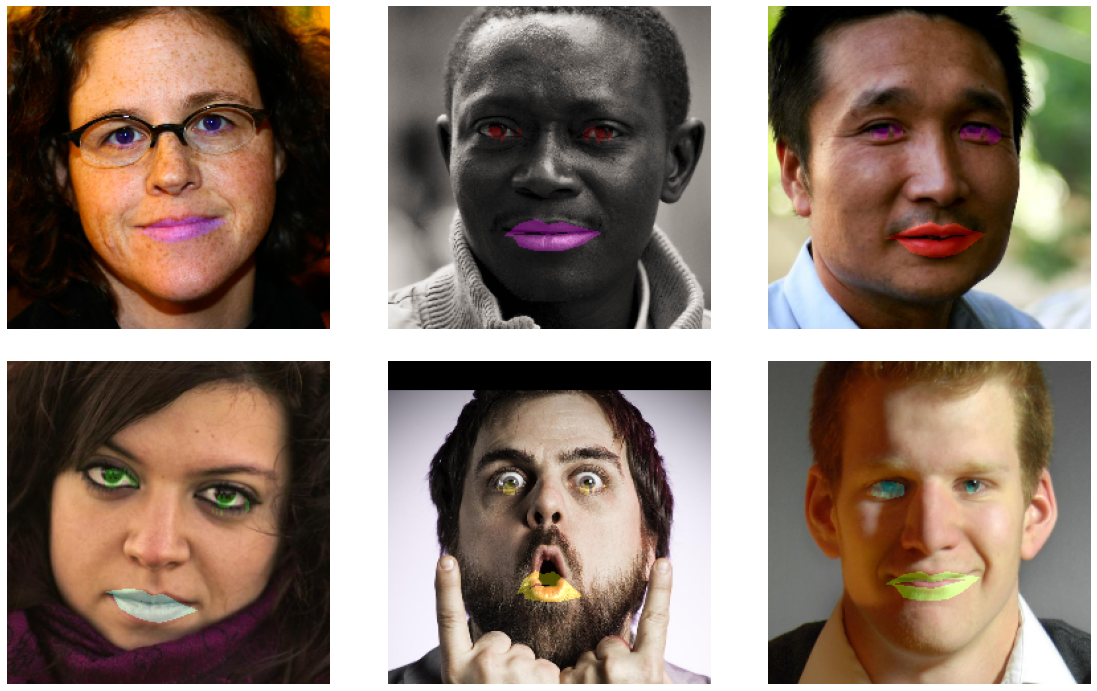

In [ ]:
fig, axxs = plt.subplots(2,3,figsize=(16,10))
fig.tight_layout()
r = 1
colors = [(0,0,255),(0,255,0),(255,0,0),(255,255,0),(255,0,255),(0,255,255)]
o = 0
for g in [0,2,4]:
  e_mask = eyeMask(examples_original[g],e_pred[g])
  iris_mask = irisMask(e_mask,examples_original[g])
  plot = changeIrisColor(examples_original[g],iris_mask,color=colors[g])
  axxs[0,o].imshow(Lipstick(plot,e_pred[g],color=colors[-g]))
  axxs[0,o].axis('off')
  g = g+1
  e_mask = eyeMask(examples_original[g],e_pred[g])
  iris_mask = irisMask(e_mask,examples_original[g])
  plot = changeIrisColor(examples_original[g],iris_mask,color=colors[(g)])
  axxs[1,o].imshow(Lipstick(plot,e_pred[g],color=colors[-g]))
  axxs[1,o].axis('off')
  o += 1
#fig.savefig('/content/drive/MyDrive/Colab Notebooks/CV assignment/figures/makeup')